# CPC - Prueba Machine Learning

## Contexto
Eres un Data Scientist en una empresa financiera que se especializa en ofrecer tarjetas de crédito a sus clientes. La compañía quiere mejorar su capacidad para evaluar el riesgo de crédito de sus clientes y, de este modo, tomar decisiones más informadas sobre la aprobación de nuevas solicitudes de tarjetas de crédito.

## Objetivo
Tu objetivo es crear un modelo de machine learning que pueda predecir si un cliente es "Bueno" o "Malo" en términos de su estado de crédito basado en varias características financieras y demográficas. Utilizarás un dataset ficticio que contiene datos relevantes de 10,000 clientes. 

Debes entregar un informe que incluya, al menos:

- Análisis Exploratorio de Datos: Gráficos y estadísticas descriptivas.
- Preprocesamiento de Datos: Descripción de cómo se manejaron los datos faltantes y las transformaciones realizadas.
- Entrenamiento y Evaluación del Modelo: Descripción de los modelos utilizados, su precisión y las características más importantes. Usar metodo tradicional, machine learning y deep learning.
- Optimización del Modelo: Descripción del proceso de optimización y los resultados obtenidos.
- Interpretación de Resultados: Conclusiones y recomendaciones basadas en los resultados del modelo y explicabilidad del mismo.
- Monitorización

Se valorarán cosas como: qué tipo de algoritmo has utilizado, si has decidido hacer búsqueda o no de hiperparámetros, qué técnicas de explicabilidad y por qué, qué transformaciones has realizado, si hay o no overfitting, qué haría para mejorar el modelo, como monitorizarías el modelo... etc

## Dataset
El dataset contiene 10.000 registros con las siguientes características:

- CustomerID: Identificador único para cada cliente.
- Age: Edad del cliente.
- MonthlyIncome: Ingresos mensuales del cliente.
- TotalDebt: Deuda total del cliente.
- CreditLimit: Límite de crédito total del cliente.
- PaymentHistory: Historial de pagos (On Time / Late).
- NumberOfCreditCards: Número de tarjetas de crédito del cliente.
- YearsWithCompany: Años que el cliente ha estado con la compañía.
- AverageMonthlyBalance: Saldo promedio mensual en sus tarjetas de crédito.
- CreditStatus: Estado del crédito (Good / Bad), que es la variable objetivo.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import shap
import os

In [2]:
class CONFIG:

    # Paths
    DATA_DIR = os.path.join('./', 'data')
    DATA_PATH = os.path.join(DATA_DIR, 'datos_ml_caixabank.csv')
    
    # Target and Features
    TARGET = 'CreditStatus'
    CAT_COLS = [
                'PaymentHistory',
    ]
    NUM_COLS = [
                'Age', 
                'MonthlyIncome', 
                'TotalDebt', 
                'CreditLimit',
                'NumberOfCreditCards',
                'YearsWithCompany',
                'AverageMonthlyBalance',
    ]

    # Model and Training Parameters
    SEED = 23
    N_FOLDS = 5

# Data Processing and EDA

In [3]:
class DataProcessor(CONFIG):
    
    def __init__(self):
        pass

    def load_data(self, path):

        df = pd.read_csv(path, sep = ";")
        df.set_index('CustomerID', inplace=True)

        # # set data types for memory efficiency
        df[CONFIG.NUM_COLS] = df[CONFIG.NUM_COLS].astype(np.int16)
        df[CONFIG.CAT_COLS] = df[CONFIG.CAT_COLS].astype('category')

        return df
    
    def clean_data(self, df):
        
        # Convert target to boolean
        df[CONFIG.TARGET] = np.where(df[CONFIG.TARGET] == 'Bad', 1, 0).astype(np.int8)

        return df

    def feature_engineering(self, df):
        
        # Create new NumberOfCreditCards as categorical
        df['NumberOfCreditCards_cat'] = df['NumberOfCreditCards'].astype('category')

        new_cat_cols = ['NumberOfCreditCards_cat']

        return df, new_cat_cols

    def process_data(self, path):

        df = self.load_data(path)
        df = self.clean_data(df)
        df, new_cat_cols = self.feature_engineering(df)

        return df, new_cat_cols

In [4]:
dp = DataProcessor()

data, new_cat_cols = dp.process_data(CONFIG.DATA_PATH)
CONFIG.CAT_COLS.extend(new_cat_cols)

#Print data information
print(f"Data shape: {data.shape}")

print(f"Number of categorical columns: {len(CONFIG.CAT_COLS)}")
print(f"Number of numerical columns: {len(CONFIG.NUM_COLS)}")
print(f"% target distribution in train data: {data[CONFIG.TARGET].value_counts(normalize=True)}")

print("*"*50)
print("DATASET IS BALANCED")
print("*"*50)

Data shape: (10000, 10)
Number of categorical columns: 2
Number of numerical columns: 7
% target distribution in train data: CreditStatus
0    0.5685
1    0.4315
Name: proportion, dtype: float64
**************************************************
DATASET IS BALANCED
**************************************************


In [5]:
data['PaymentHistory'].value_counts() # Could be converted to boolean

PaymentHistory
On Time    9010
Late        990
Name: count, dtype: int64

In [6]:
data.isnull().sum() # No missing values in the dataset

Age                        0
MonthlyIncome              0
TotalDebt                  0
CreditLimit                0
PaymentHistory             0
NumberOfCreditCards        0
YearsWithCompany           0
AverageMonthlyBalance      0
CreditStatus               0
NumberOfCreditCards_cat    0
dtype: int64

## Numerical variables

In [7]:
for col in CONFIG.NUM_COLS:
    if data[col].nunique() < 10:
        print(data[col].value_counts(normalize=True))
        print("-"*50)

# NumberOfCreditCards could potentially be used as categorical

NumberOfCreditCards
2    0.2042
5    0.2001
4    0.1997
1    0.1989
3    0.1971
Name: proportion, dtype: float64
--------------------------------------------------


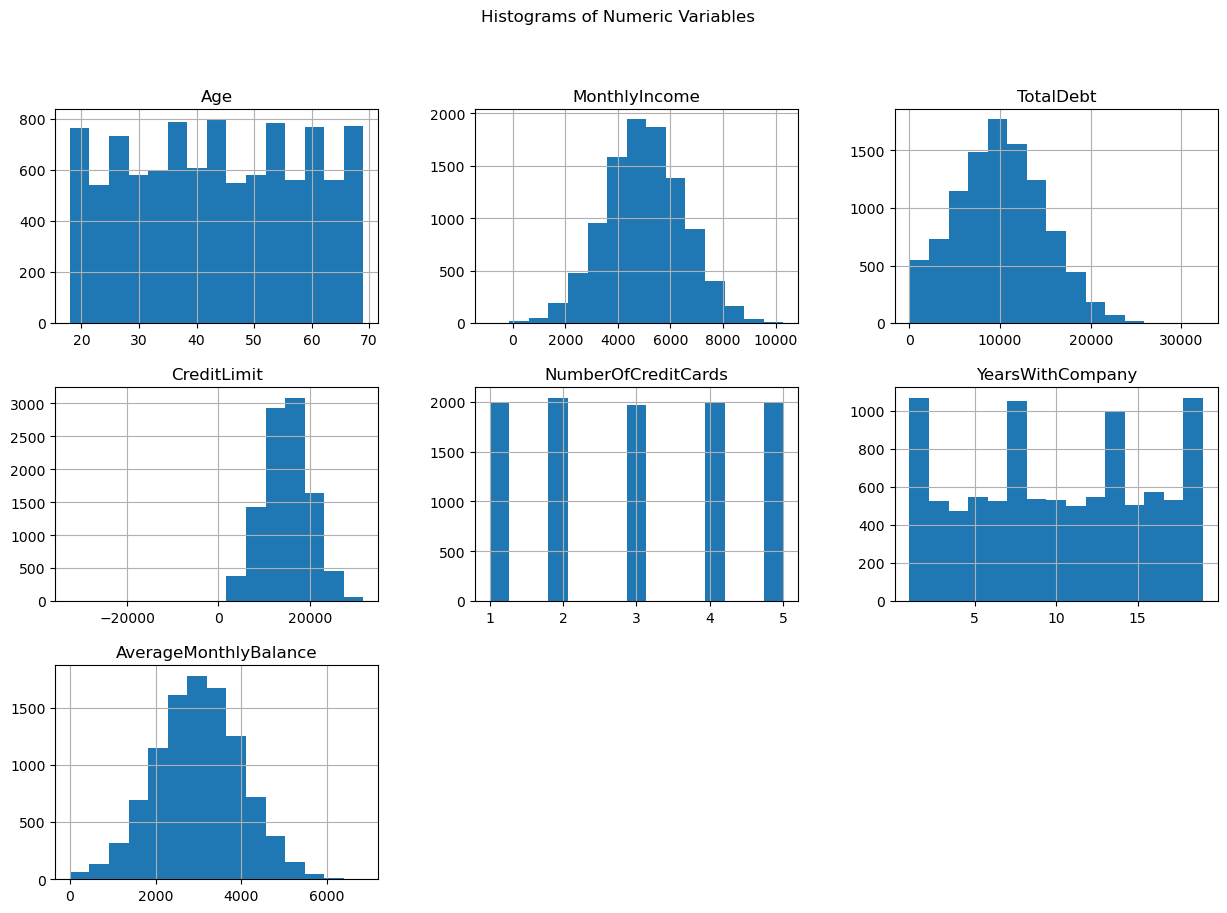

In [8]:
from src.utils.helpers import InitialEDA

InitialEDA.plot_histograms(data, CONFIG.NUM_COLS)
# Distribution of numerical variables seems ok, normally distributed or discrete
# no need of log transformations or removal of outliers

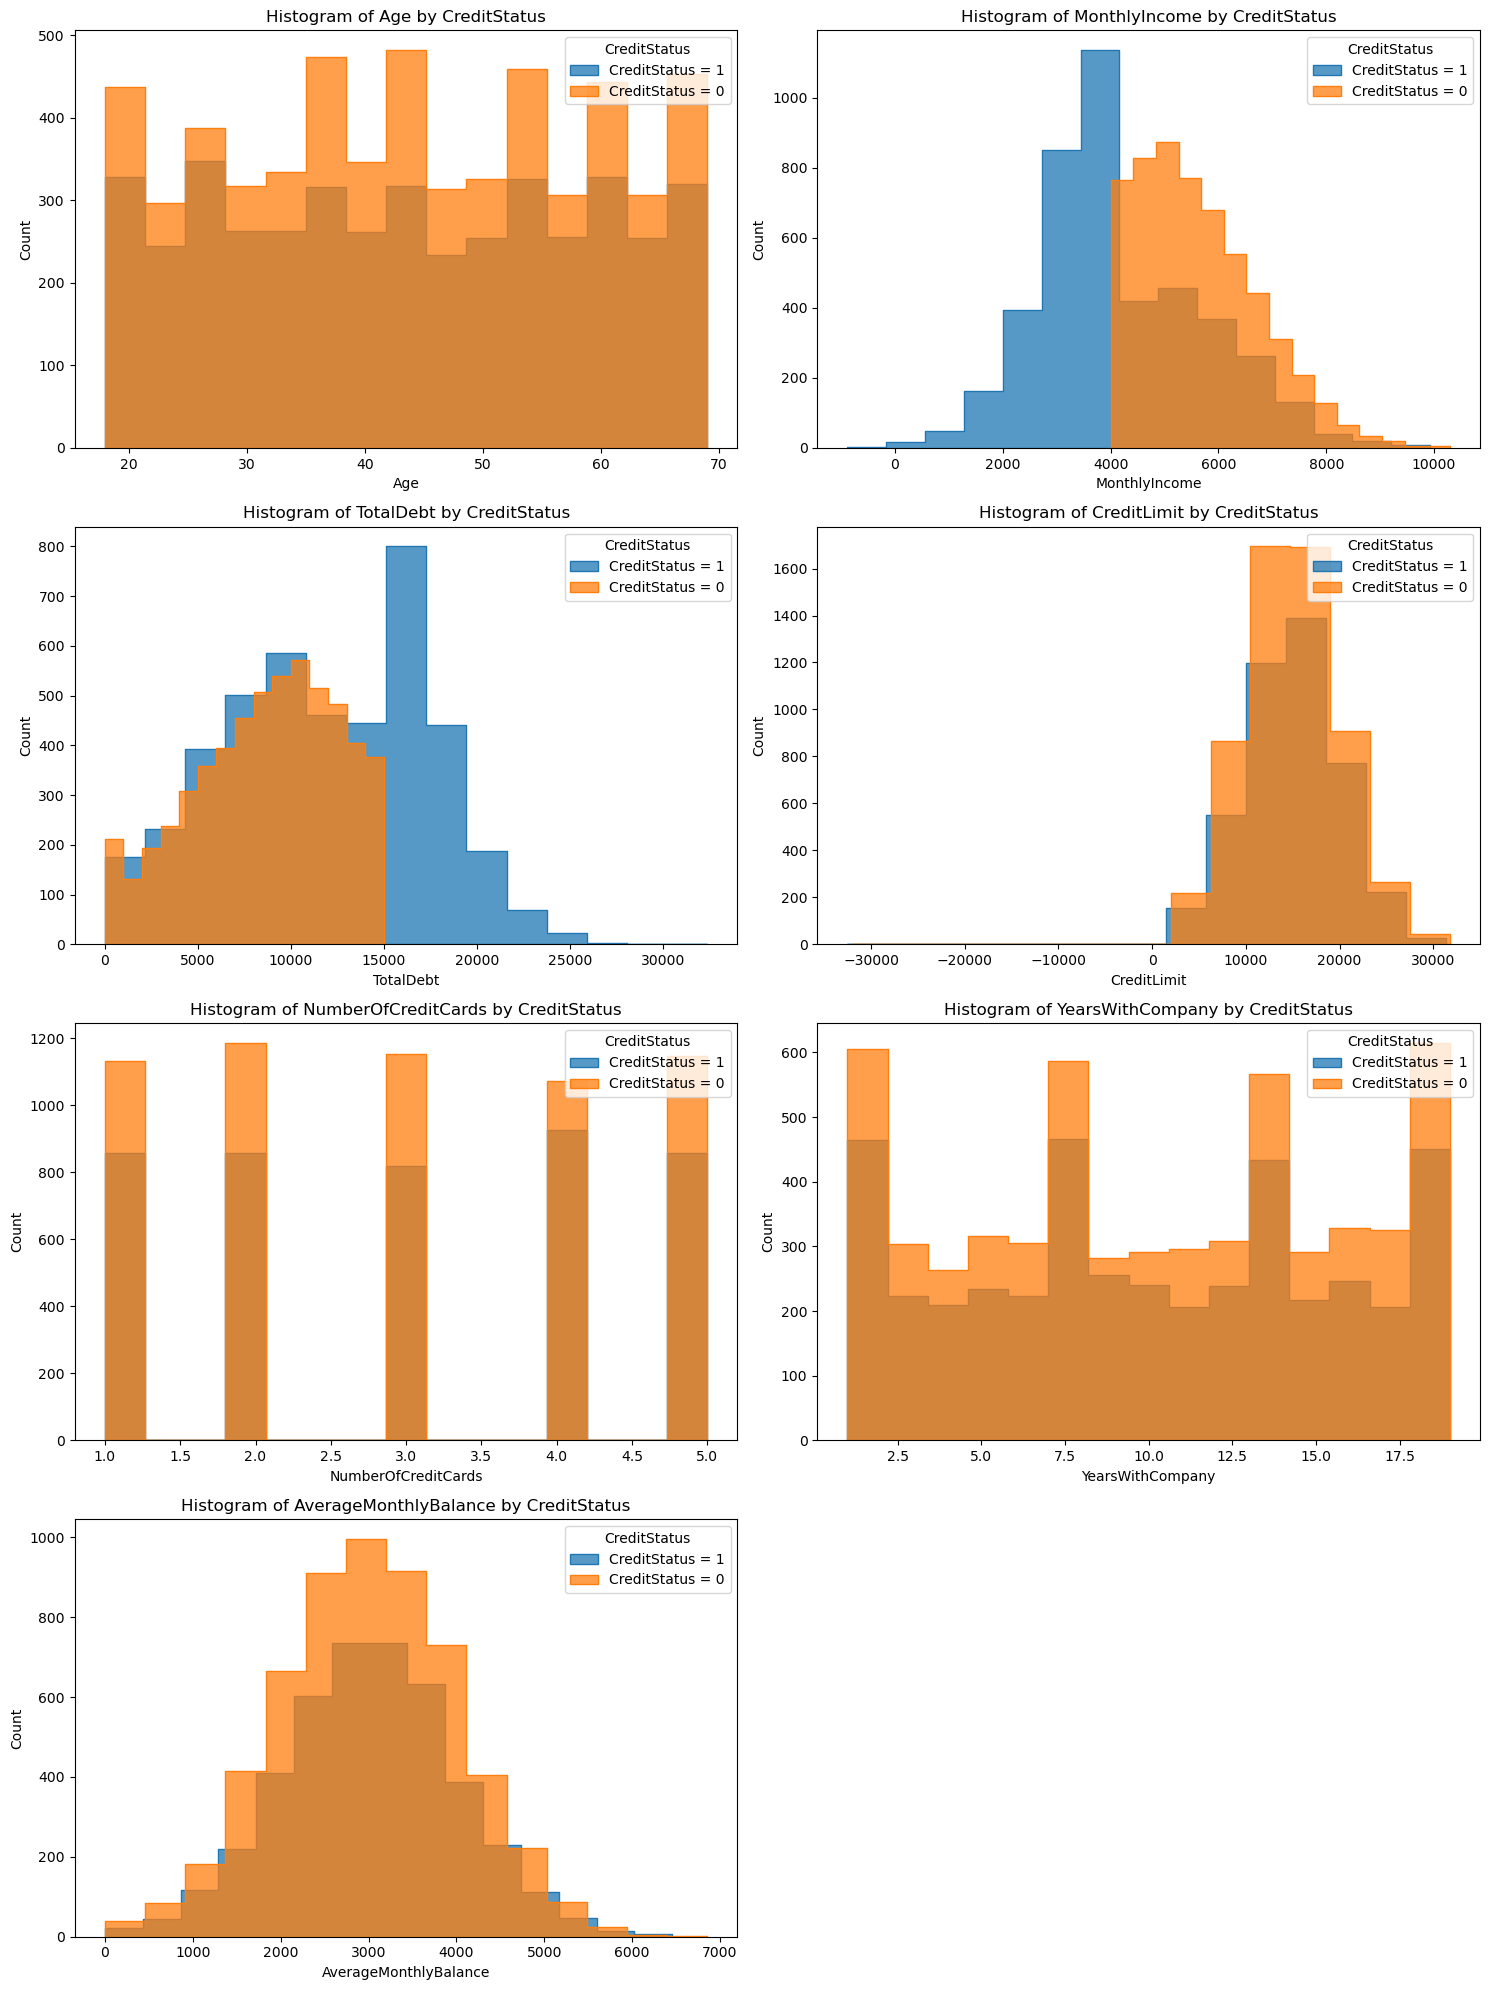

In [9]:
InitialEDA.plot_histograms_classes(data, CONFIG.TARGET, CONFIG.NUM_COLS)
# MonthlyIncome and TotalDebt seem to be the most directly related to target distribution

# Categorical variables

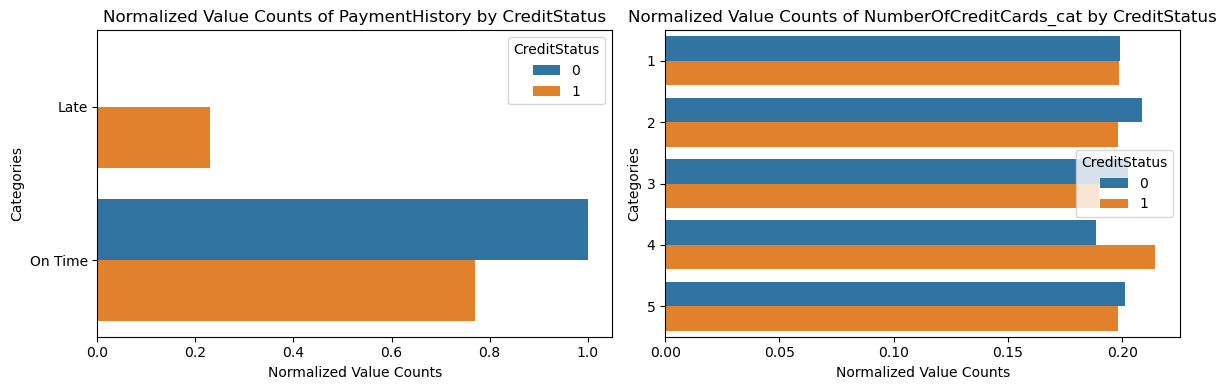

In [10]:
InitialEDA.plot_barplots_normalized(data, CONFIG.TARGET, cat_cols=CONFIG.CAT_COLS)

# PaymentHistory also associates with risk

# Correlation to target

In [14]:
data.corr(numeric_only=True).style.background_gradient(cmap='coolwarm')

,Age,MonthlyIncome,TotalDebt,CreditLimit,NumberOfCreditCards,YearsWithCompany,AverageMonthlyBalance,CreditStatus
Age,1.000000,-0.004087,-0.026692,0.001194,-0.015311,0.006701,0.010554,-0.012180
MonthlyIncome,-0.004087,1.000000,0.002896,0.019094,-0.012771,-0.003992,-0.012693,-0.486861
TotalDebt,-0.026692,0.002896,1.000000,0.014729,-0.015428,-0.006800,0.004909,0.327647
CreditLimit,0.001194,0.019094,0.014729,1.000000,-0.019695,-0.005098,-0.011628,-0.005841
NumberOfCreditCards,-0.015311,-0.012771,-0.015428,-0.019695,1.000000,0.004044,-0.006206,0.010717
YearsWithCompany,0.006701,-0.003992,-0.006800,-0.005098,0.004044,1.000000,-0.002530,-0.010591
AverageMonthlyBalance,0.010554,-0.012693,0.004909,-0.011628,-0.006206,-0.002530,1.000000,0.011112
CreditStatus,-0.012180,-0.486861,0.327647,-0.005841,0.010717,-0.010591,0.011112,1.000000
